In [1]:
# Importing required libraries/dependencies
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
get_ipython().run_line_magic('matplotlib', 'inline')
import itertools
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd, datetime
from pandas import DataFrame
import seaborn as sns
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from time import time
from unicodedata import normalize
import xgboost as xgb

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


# Importing training data provided by Kaggle 

In [2]:
#  Import and read the charity_data.csv.
# import pandas as pd 
# application_df = pd.read_csv("Resources/charity_data.csv")
# application_df.head()
train_df = pd.read_csv('/gdrive/MyDrive/project4/Tanner/Resources/grocery_train.csv')
train_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


# Preparing training dataframe for supervised machine learning 

In [3]:
# check for null values in the dateset 
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [4]:
# drop store and id columns 
cleaned_train = train_df.drop(['id', 'store_nbr', 'family', 'onpromotion'], axis =1)
cleaned_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   date    object 
 1   sales   float64
dtypes: float64(1), object(1)
memory usage: 45.8+ MB


In [5]:
# convert 'date' column to datetime format for merging with other CSV's 
cleaned_train['date'] = pd.to_datetime(cleaned_train['date'])
cleaned_train.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [6]:
# converting date to a Month period, and then summing the number of items in each month 
cleaned_train['date'] = cleaned_train['date'].dt.to_period("M")
# cleaned_train['date'] = cleaned_train['date'].dt.month
monthly_sales = cleaned_train.groupby('date').sum().reset_index()
monthly_sales.head()

,date,sales
0,2013-01,1.032762e+07
1,2013-02,9.658960e+06
2,2013-03,1.142850e+07
3,2013-04,1.099346e+07
4,2013-05,1.159770e+07


In [52]:
# convert the resulting date column to timestamp datatype 
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head()

AttributeError: ignored

<function matplotlib.pyplot.show(close=None, block=None)>

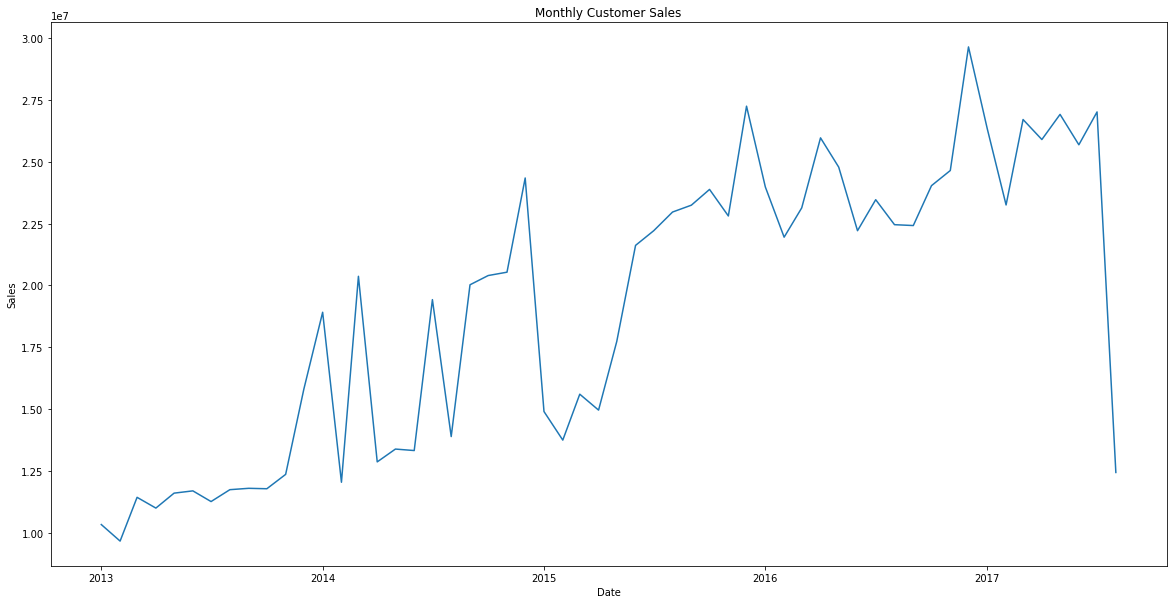

In [ ]:
# Visualization
plt.figure(figsize=(20,10))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show

In [51]:
# call the difference on the sales columns to make the sales data stationary, remember 2013-02-01 reflects sales for the entire previous month (JANUARY)
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head()

<ipython-input-51-40e6a3370f69>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_sales['sales_diff'] = monthly_sales['sales'].diff()


,date,sales,sales_diff
2,2013-03-01,1.142850e+07,1.769537e+06
3,2013-04-01,1.099346e+07,-4.350323e+05
4,2013-05-01,1.159770e+07,6.042393e+05
5,2013-06-01,1.168934e+07,9.164006e+04
6,2013-07-01,1.125740e+07,-4.319435e+05


<function matplotlib.pyplot.show(close=None, block=None)>

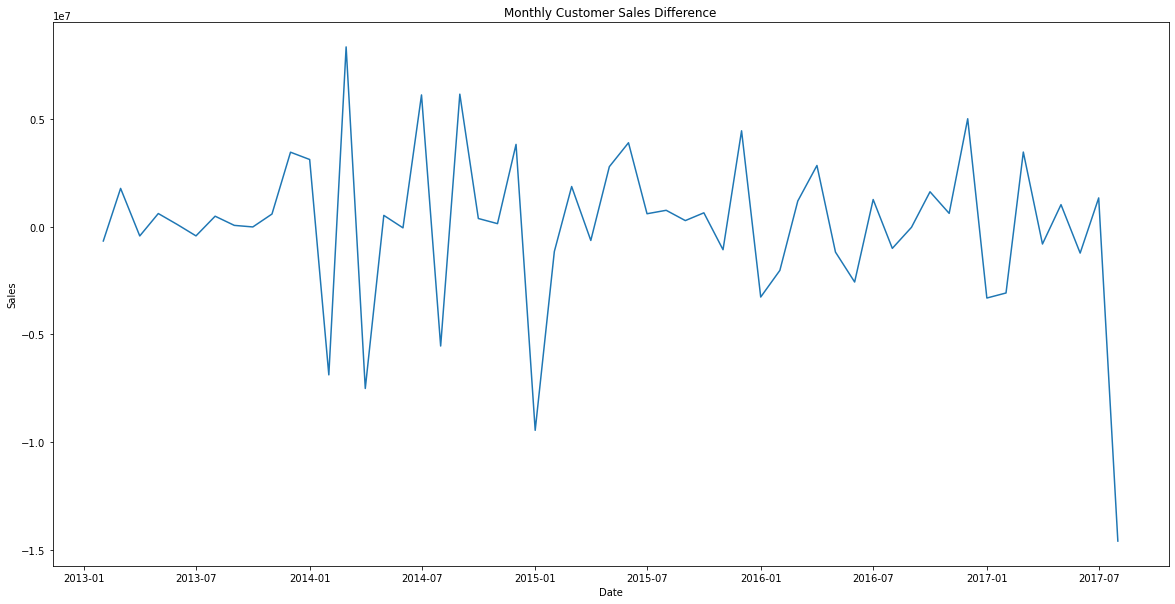

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales Difference")
plt.show

In [50]:
#dropping off sales and date 
supervised_data = monthly_sales.drop(['date', 'sales'], axis = 1)
supervised_data.head()

,sales_diff
1,-6.686650e+05
2,1.769537e+06
3,-4.350323e+05
4,6.042393e+05
5,9.164006e+04


In [10]:
#preparing the supervised data, we got the sales difference for all stores 
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head()

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-6.873288e+06,3.108524e+06,3.446558e+06,5.809389e+05,-1.731287e+04,5.514431e+04,4.803883e+05,-431943.454563,91640.055217,604239.269015,-435032.299476,1.769537e+06,-6.686650e+05
1,8.327231e+06,-6.873288e+06,3.108524e+06,3.446558e+06,5.809389e+05,-1.731287e+04,5.514431e+04,480388.311792,-431943.454563,91640.055217,604239.269015,-4.350323e+05,1.769537e+06
2,-7.504333e+06,8.327231e+06,-6.873288e+06,3.108524e+06,3.446558e+06,5.809389e+05,-1.731287e+04,55144.312395,480388.311792,-431943.454563,91640.055217,6.042393e+05,-4.350323e+05
3,5.185342e+05,-7.504333e+06,8.327231e+06,-6.873288e+06,3.108524e+06,3.446558e+06,5.809389e+05,-17312.871349,55144.312395,480388.311792,-431943.454563,9.164006e+04,6.042393e+05
4,-5.982709e+04,5.185342e+05,-7.504333e+06,8.327231e+06,-6.873288e+06,3.108524e+06,3.446558e+06,580938.932467,-17312.871349,55144.312395,480388.311792,-4.319435e+05,9.164006e+04


In [11]:
# split the data into Train and Test 
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (31, 13)
Test Data Shape:  (12, 13)


In [12]:
# scaling feature values to restrict them to indicated feature range
scaler = MinMaxScaler(feature_range=(-1,1))
# fit the train data within the scaler 
scaler.fit(train_data)
# transforming train and test data 
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [13]:
#  in a supervised dataframe the first column always corresponds to the output, remaining column act as the input features, this can be seen in the output of this cell 
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (31, 12)
y_train Shape:  (31,)
X_test Shape:  (12, 12)
y_test Shape:  (12,)


In [14]:
# create prediction dataframe ti merge the predicted sales of all trained algorithms 
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [15]:
 # creating dataframe to hold the actual sales of the last 13 months 
 actual_sales = monthly_sales['sales'][-13:].to_list()
 actual_sales

[22452414.3178949,
 22417448.0969967,
 24030389.816292,
 24642640.1973935,
 29640287.5793851,
 26328159.9357051,
 23250112.3749368,
 26704017.6908793,
 25895308.4895551,
 26911847.250593,
 25682822.1249936,
 27011477.5658307,
 12433322.9407775]

# Beginning of linear regression Section

In [16]:
# create linear regression model and predicted output 
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predict = lr_model.predict(X_test)

In [17]:
# we need to transform the predicted values back to their original scale 
lr_predict = lr_predict.reshape(-1,1)
# notice that the brackets are needed in the line below because we are passing in a list/array 
lr_predict_test = np.concatenate([lr_pre, X_test], axis = 1)
lr_predict_test = scaler.inverse_transform(lr_predict_test)

NameError: ignored

# Reading in and cleaning test data from Kaggle 

In [18]:
test_df = pd.read_csv('/gdrive/MyDrive/project4/Tanner/Resources/grocery_test.csv')
test_df

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [19]:
# check for null values in the dateset 
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [20]:
# drop store and id columns 
cleaned_test = test_df.drop(['id', 'store_nbr', 'family', 'onpromotion'], axis =1)
cleaned_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    28512 non-null  object
dtypes: object(1)
memory usage: 222.9+ KB


# Preparing training data for unsupervised machine learning 

In [21]:
# counting number of rows in training set prior to cleaning 
len(train_df)


3000888

In [22]:
# convert 'date' column to datetime format for merging with other CSV's 
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [23]:
# read in the holiday data file 
# holiday_file = "resources/holidays_events.csv"
# holiday_df = pd.read_csv(holiday_file)
# holiday_df.tail()

holiday_df = pd.read_csv('/gdrive/MyDrive/project4/Tanner/Resources/holiday.csv')
holiday_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [24]:
# counting number of rows in holiday df 
len(holiday_df)

350

In [25]:
# converting date column from string to datetime format 
holiday_df['date'] = pd.to_datetime(holiday_df['date'])
holiday_df.dtypes

date           datetime64[ns]
type                   object
locale                 object
locale_name            object
description            object
transferred              bool
dtype: object

In [26]:
#drop rows that notate whether the holiday was moved by the government 
cleaned_hol = holiday_df[holiday_df['transferred'] == False]

In [27]:
# checking how many holidays were affected by this (twelve total )
len(cleaned_hol)

338

In [28]:
cleaned_hol.drop_duplicates(subset='date', inplace=True)
len(cleaned_hol)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


300

In [29]:
# drop transferred, cluster and type_x column 
holiday_df = cleaned_hol.drop(['type', "locale_name", "transferred" ], axis=1)
holiday_df

,date,locale,description
0,2012-03-02,Local,Fundacion de Manta
1,2012-04-01,Regional,Provincializacion de Cotopaxi
2,2012-04-12,Local,Fundacion de Cuenca
3,2012-04-14,Local,Cantonizacion de Libertad
4,2012-04-21,Local,Cantonizacion de Riobamba
...,...,...,...
344,2017-12-22,Local,Cantonizacion de Salinas
346,2017-12-23,National,Navidad-2
347,2017-12-24,National,Navidad-1
348,2017-12-25,National,Navidad


In [30]:
merged_holiday = pd.merge(train_df, holiday_df, on ='date', how="left")
merged_holiday

,id,date,store_nbr,family,sales,onpromotion,locale,description
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano
1,1,2013-01-01,1,BABY CARE,0.000,0,National,Primer dia del ano
2,2,2013-01-01,1,BEAUTY,0.000,0,National,Primer dia del ano
3,3,2013-01-01,1,BEVERAGES,0.000,0,National,Primer dia del ano
4,4,2013-01-01,1,BOOKS,0.000,0,National,Primer dia del ano
...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba


In [31]:
len(merged_holiday)

3000888

In [32]:
# # Read in the oil prices data file 
# oil_file = "resources/oil.csv"
# oil_df = pd.read_csv(oil_file)
# oil_df.head()

oil_df = pd.read_csv('/gdrive/MyDrive/project4/Tanner/Resources/oil.csv')
oil_df

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [33]:
# drop null values from oil dataframe/csv
cleaned_oil=oil_df.dropna()
cleaned_oil

,date,dcoilwtico
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [34]:
cleaned_oil['date'] = pd.to_datetime(cleaned_oil['date'])
cleaned_oil.dtypes

<ipython-input-34-b014fd391d71>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_oil['date'] = pd.to_datetime(cleaned_oil['date'])


date          datetime64[ns]
dcoilwtico           float64
dtype: object

In [35]:
final_train = pd.merge(merged_holiday, cleaned_oil, on ='date', how="left")
final_train

,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,National,Primer dia del ano,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,National,Primer dia del ano,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,National,Primer dia del ano,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,National,Primer dia del ano,NaN
...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57


In [36]:
len(final_train)

3000888

In [37]:
# Since the dataframe starts and ends on a Tuesday (1 = Tuesday 2 = Wednesday etc.)
final_train['weekdaynumber'] = final_train['date'].dt.dayofweek
# adding in week of year for further analysis/visualizations, Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead
final_train['week_of_year'] = final_train['date'].dt.weekofyear
final_train

<ipython-input-37-bbe27f20fd35>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  final_train['week_of_year'] = final_train['date'].dt.weekofyear


,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,weekdaynumber,week_of_year
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano,NaN,1,1
1,1,2013-01-01,1,BABY CARE,0.000,0,National,Primer dia del ano,NaN,1,1
2,2,2013-01-01,1,BEAUTY,0.000,0,National,Primer dia del ano,NaN,1,1
3,3,2013-01-01,1,BEVERAGES,0.000,0,National,Primer dia del ano,NaN,1,1
4,4,2013-01-01,1,BOOKS,0.000,0,National,Primer dia del ano,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,1,33
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,1,33
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,1,33
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57,1,33


In [38]:
# adding day of week name for employee scheduling analysis etc. 
final_train['weekday']= final_train['date'].dt.day_name()
final_train

,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,weekdaynumber,week_of_year,weekday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,1,33,Tuesday
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,1,33,Tuesday
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,1,33,Tuesday
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57,1,33,Tuesday


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


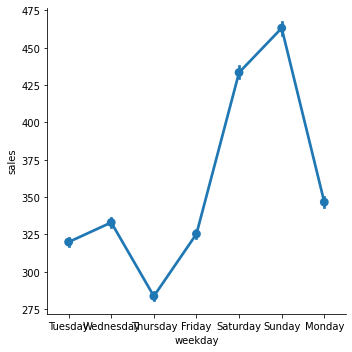

In [ ]:
# Sales trend over days, **************** DO NOT RE-RUN this cell, stick with saved output -- takes too long to run otherwise *****************
sns.factorplot(data = final_train, x = "weekday", y = "sales")

In [39]:
# adding year and month columns for possible visualizations 
final_train['year'] = final_train['date'].dt.year
final_train['month'] = final_train['date'].dt.month
final_train

,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,weekdaynumber,week_of_year,weekday,year,month
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday,2013,1
1,1,2013-01-01,1,BABY CARE,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday,2013,1
2,2,2013-01-01,1,BEAUTY,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday,2013,1
3,3,2013-01-01,1,BEVERAGES,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday,2013,1
4,4,2013-01-01,1,BOOKS,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday,2013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8


In [40]:
# counting number of non-holidays in df 
nan_count = final_train['locale'].isna().sum()
nan_count

2567862

In [41]:
# replacing NaN holiday description cells with 0 
final_train['locale'] = final_train['locale'].fillna(0)

In [42]:
# setting dates that fall on a holiday = to 1 in holiday column 
final_train['holiday'] = final_train['locale'].replace({'National': 1, 'Local': 1, 'Regional': 1})
final_train

,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,weekdaynumber,week_of_year,weekday,year,month,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday,2013,1,1
1,1,2013-01-01,1,BABY CARE,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday,2013,1,1
2,2,2013-01-01,1,BEAUTY,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday,2013,1,1
3,3,2013-01-01,1,BEVERAGES,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday,2013,1,1
4,4,2013-01-01,1,BOOKS,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday,2013,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1


In [43]:
# check volume of holiday or not 
print(final_train['holiday'].value_counts())

0    2567862
1     433026
Name: holiday, dtype: int64


In [44]:
# adding quarter column for further analysis 
final_train['quarter'] = pd.PeriodIndex(final_train.date, freq='Q')
final_train

,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,weekdaynumber,week_of_year,weekday,year,month,holiday,quarter
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday,2013,1,1,2013Q1
1,1,2013-01-01,1,BABY CARE,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday,2013,1,1,2013Q1
2,2,2013-01-01,1,BEAUTY,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday,2013,1,1,2013Q1
3,3,2013-01-01,1,BEVERAGES,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday,2013,1,1,2013Q1
4,4,2013-01-01,1,BOOKS,0.000,0,National,Primer dia del ano,NaN,1,1,Tuesday,2013,1,1,2013Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1,2017Q3
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1,2017Q3
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1,2017Q3
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1,2017Q3


In [45]:
# check data types for SQL compatibility 
final_train.dtypes

id                        int64
date             datetime64[ns]
store_nbr                 int64
family                   object
sales                   float64
onpromotion               int64
locale                   object
description              object
dcoilwtico              float64
weekdaynumber             int64
week_of_year              int64
weekday                  object
year                      int64
month                     int64
holiday                   int64
quarter           period[Q-DEC]
dtype: object



```
# Creating separate training set for oil models 

> this df will have fewer rows due to missing data

In [46]:
oil_train=final_train.dropna(subset=['dcoilwtico'])
oil_train

,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,weekdaynumber,week_of_year,weekday,year,month,holiday,quarter
1782,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,0,NaN,93.14,2,1,Wednesday,2013,1,0,2013Q1
1783,1783,2013-01-02,1,BABY CARE,0.000,0,0,NaN,93.14,2,1,Wednesday,2013,1,0,2013Q1
1784,1784,2013-01-02,1,BEAUTY,2.000,0,0,NaN,93.14,2,1,Wednesday,2013,1,0,2013Q1
1785,1785,2013-01-02,1,BEVERAGES,1091.000,0,0,NaN,93.14,2,1,Wednesday,2013,1,0,2013Q1
1786,1786,2013-01-02,1,BOOKS,0.000,0,0,NaN,93.14,2,1,Wednesday,2013,1,0,2013Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1,2017Q3
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1,2017Q3
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1,2017Q3
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1,2017Q3


In [47]:
# display zero in oil_price column if oil price is below $75 per barrel and a one on days when oil price is above $75 per barrel 
oil_train["oil_price"] = np.where(oil_train["dcoilwtico"] > 75, 0, 1)
oil_train

<ipython-input-47-9663669ff8f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_train["oil_price"] = np.where(oil_train["dcoilwtico"] > 75, 0, 1)


,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,weekdaynumber,week_of_year,weekday,year,month,holiday,quarter,oil_price
1782,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,0,NaN,93.14,2,1,Wednesday,2013,1,0,2013Q1,0
1783,1783,2013-01-02,1,BABY CARE,0.000,0,0,NaN,93.14,2,1,Wednesday,2013,1,0,2013Q1,0
1784,1784,2013-01-02,1,BEAUTY,2.000,0,0,NaN,93.14,2,1,Wednesday,2013,1,0,2013Q1,0
1785,1785,2013-01-02,1,BEVERAGES,1091.000,0,0,NaN,93.14,2,1,Wednesday,2013,1,0,2013Q1,0
1786,1786,2013-01-02,1,BOOKS,0.000,0,0,NaN,93.14,2,1,Wednesday,2013,1,0,2013Q1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1,2017Q3,1
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1,2017Q3,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1,2017Q3,1
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57,1,33,Tuesday,2017,8,1,2017Q3,1


# Uncategorizing sales data by 'family' to get a per day sum 

In [48]:
# final_train['month']=final_train.groupby("date")[["onpromotion"]].sum()
# final_train['month']

daily_sales = final_train.groupby('date').sum().reset_index()
daily_sales.head()

,date,id,store_nbr,sales,onpromotion,dcoilwtico,weekdaynumber,week_of_year,year,month,holiday
0,2013-01-01,1586871,49005,2511.618999,0,0.00,1782,1782,3587166,1782,1782
1,2013-01-02,4762395,49005,496092.417944,0,165975.48,3564,1782,3587166,1782,0
2,2013-01-03,7937919,49005,361461.231124,0,165672.54,5346,1782,3587166,1782,0
3,2013-01-04,11113443,49005,354459.677093,0,165939.84,7128,1782,3587166,1782,0
4,2013-01-05,14288967,49005,477350.121229,0,0.00,8910,1782,3587166,1782,1782


In [ ]:
daily_sales.dtypes

id                        int64
date             datetime64[ns]
store_nbr                 int64
family                   object
sales                   float64
onpromotion               int64
locale                   object
description              object
dcoilwtico              float64
weekdaynumber             int64
weekday                  object
year                      int64
month                   float64
holiday                 float64
dtype: object

In [ ]:
# Sales trend over the months and year, remember to change factorplot to catplot 
sns.factorplot(data = final_train, x ="month", y = "sales", 
               col = 'store_nbr', # per store type in cols
               row = "year")

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


In [ ]:
indexed_train = final_train.set_index('date')
indexed_train

,id,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,weekdaynumber,weekday,year,month,holiday
date,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano,NaN,1,Tuesday,2013,NaN,0.0
2013-01-01,1,1,BABY CARE,0.000,0,National,Primer dia del ano,NaN,1,Tuesday,2013,NaN,0.0
2013-01-01,2,1,BEAUTY,0.000,0,National,Primer dia del ano,NaN,1,Tuesday,2013,NaN,0.0
2013-01-01,3,1,BEVERAGES,0.000,0,National,Primer dia del ano,NaN,1,Tuesday,2013,NaN,0.0
2013-01-01,4,1,BOOKS,0.000,0,National,Primer dia del ano,NaN,1,Tuesday,2013,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,1,Tuesday,2017,NaN,0.0
2017-08-15,3000884,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,1,Tuesday,2017,NaN,0.0
2017-08-15,3000885,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,1,Tuesday,2017,NaN,0.0


# Visualizations Section: Move all plots to this section *****

<AxesSubplot:xlabel='date'>

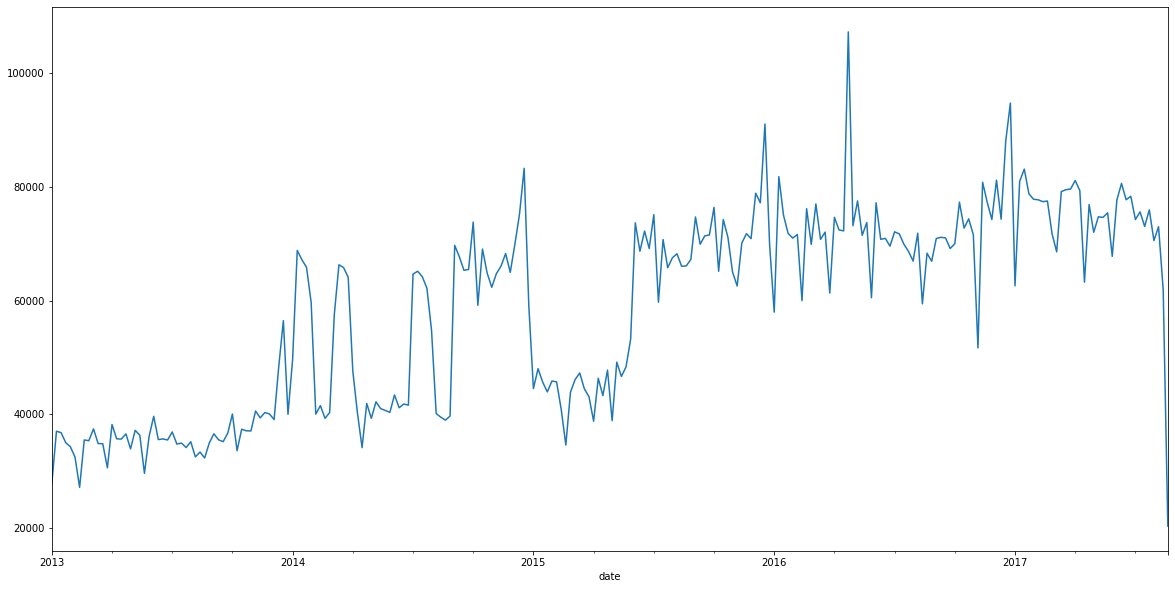

In [ ]:
# Data Preparation: input should be float type
indexed_train['sales'] = indexed_train['sales'] * 1.0
# Assigning one store from each category
sales_a = indexed_train[indexed_train.store_nbr == 1]['sales']
# Trend
sales_a.resample('W').sum().plot(figsize=(20, 10))

In [ ]:
indexed_final_train = final_train.set_index('date')
indexed_final_train

,id,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico
date,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano,NaN
2013-01-01,1,1,BABY CARE,0.000,0,National,Primer dia del ano,NaN
2013-01-01,2,1,BEAUTY,0.000,0,National,Primer dia del ano,NaN
2013-01-01,3,1,BEVERAGES,0.000,0,National,Primer dia del ano,NaN
2013-01-01,4,1,BOOKS,0.000,0,National,Primer dia del ano,NaN
...,...,...,...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57
2017-08-15,3000884,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57
2017-08-15,3000885,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57


In [ ]:
indexed_final_train['date'] = indexed_final_train['date'].dt.weekday_name()

KeyError: ignored

In [ ]:
# Sales trend over the months and year
sns.factorplot(data = indexed_final_train, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year")

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


ValueError: ignored

In [ ]:
# Sales trend over days
sns.factorplot(data = indexed_final_train, x = "DayOfWeek", y = "Sales", hue = "Promo")

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


ValueError: ignored

In [ ]:
indexed_final_train = final_train.set_index('date')

In [ ]:
oil_train = final_train["dcoilwtico"].dropna()
oil_train

1782       93.14
1783       93.14
1784       93.14
1785       93.14
1786       93.14
           ...  
3000883    47.57
3000884    47.57
3000885    47.57
3000886    47.57
3000887    47.57
Name: dcoilwtico, Length: 2072466, dtype: float64

In [ ]:
# final_train.drop(final_train[final_train['dcoilwtico'] >= 24000].index, inplace = True)

In [ ]:
final_train.loc[final_train["dcoilwtico"] <= 100] = 1
final_train.loc[final_train["dcoilwtico"] > 100] = 0

In [ ]:
oil_final = final_train['dcoilwtico'].loc(final_train['dcoilwtico'] >=100 , 0, inplace=True)
# final_train['dcoilwtico'] >= 100

AttributeError: ignored

In [ ]:
onpromotion_df=final_train.groupby("date")[["onpromotion"]].sum()
onpromotion_df

,onpromotion
date,
2013-01-01,0
2013-01-02,0
2013-01-03,0
2013-01-04,0
2013-01-05,0
...,...
2017-08-11,14179
2017-08-12,8312
2017-08-13,9283


In [ ]:
#Read in the emissions data file 
transactions_file = "resources/transactions.csv"
trans_df = pd.read_csv(transactions_file)
trans_df.head()

In [ ]:
len(trans_df)

In [ ]:
# check data types for SQL compatibility 
trans_df.dtypes

In [ ]:
# convert 'date' column to datetime format for merging with other CSV's 
trans_df['date'] = pd.to_datetime(trans_df['date'])
trans_df.dtypes

In [ ]:
# we are focusing our machine learning models on thirty days from each year included 
april_df = trans_df[((trans_df['date'] >= '2013-04-16') & (trans_df['date'] < '2013-05-16'))
    | ((trans_df['date'] >= '2014-04-16') & (trans_df['date'] < '2014-05-16'))
    | ((trans_df['date'] >= '2015-04-16') & (trans_df['date'] < '2015-05-16'))
    | ((trans_df['date'] >= '2016-04-16') & (trans_df['date'] < '2016-05-16'))
    | ((trans_df['date'] >= '2017-04-16') & (trans_df['date'] < '2017-05-16'))]
april_df.head()

In [ ]:
#checking to make sure the query cut off at desired date 
april_df.tail()

In [ ]:
# printing the number of rows in our datframe for quality assurance during merges 
len(april_df)

In [ ]:
#Read in the stores data file which has location info within Ecuador 
stores_file = "resources/stores.csv"
stores_df = pd.read_csv(stores_file)
stores_df.head()

In [ ]:
# checking that store number type is int64 prior to merge 
stores_df.dtypes

In [ ]:
# performing first merge 
store_april = pd.merge(stores_df, april_df, on ='store_nbr')
store_april.head()

In [ ]:
#checking that number of rows is staying consistent 
len(store_april)

In [ ]:
# read in the holiday data file 
holiday_file = "resources/holidays_events.csv"
holiday_df = pd.read_csv(holiday_file)
holiday_df.tail()

In [ ]:
# checking length of this dataframe before cleaning it 
len(holiday_df)

In [ ]:
# since merge will take place on date column this datatype will need to be converted 
holiday_df.dtypes

In [ ]:
# performing conversion 
holiday_df['date'] = pd.to_datetime(holiday_df['date'])
holiday_df.dtypes

In [ ]:
# excluding rows that cintain  official gvt observance info  
cleaned_hol = holiday_df[holiday_df['transferred'] == False]

In [ ]:
# checking that rows were removed
len(cleaned_hol)

In [ ]:
#removing duplicate rows before merging 
cleaned_hol.drop_duplicates(subset='date', inplace=True)
len(cleaned_hol)

In [ ]:
# performing left join to prevent rows being added during merge 
merged_holiday = pd.merge(store_april, cleaned_hol, on ='date', how="left")
merged_holiday.head()

In [ ]:
# confirming that number of rows is staying consistent 
len(merged_holiday)

In [ ]:
# Read in the oil prices data file 
oil_file = "resources/oil.csv"
oil_df = pd.read_csv(oil_file)
oil_df.head()

In [ ]:
# drop null values from oil dataframe/csv
cleaned_oil=oil_df.dropna()
cleaned_oil.head()

In [ ]:
cleaned_oil['date'] = pd.to_datetime(cleaned_oil['date'])
cleaned_oil.dtypes

In [ ]:
# cleaned_hol.squeeze()
indexed_oil = cleaned_oil.set_index('date', inplace=True)

In [ ]:
cleaned_df = pd.concat([merged_holiday, indexed_oil], axis=1)
len(cleaned_df)

In [ ]:
# cleaned_df = pd.merge(trans_store_hol, cleaned_oil, on ='date')
cleaned_df.head()

In [ ]:
# drop transferred, cluster and type_x column 
final_df = cleaned_df.drop(['type_x', "cluster", "transferred" ], axis=1)
final_df.head()

In [ ]:
final_df.dtypes

In [ ]:
len(final_df)

In [ ]:
#Create SQL Alchemy engine to postgres database "IMDB_db"
protocol = 'postgresql'
username = 'postgres'
password = '0206Teddy'
host = 'localhost'
port = 5432
database_name = 'grocery'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)

In [ ]:
#show the existing table names in the database
engine.table_names()

In [ ]:
#write the data in the dataframe to the database table
final_df.to_sql(name='earthquake_data', con=engine, if_exists='replace', index=False)

In [ ]:
#Query the carbon emissions data table to confirm the above data load
pd.read_sql_query('select * from public."earthquake_data"', con=engine)

In [ ]:
pd.read_sql_query('select * from public."earthquake_data"', con=engine).count()